# LLE, Marc Fischer

## Setup

In [602]:
# %matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

import sklearn.metrics

## Getting the data

In [603]:
!wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -fd train-images-idx3-ubyte.gz
!gzip -fd train-labels-idx1-ubyte.gz
!gzip -fd t10k-images-idx3-ubyte.gz
!gzip -fd t10k-labels-idx1-ubyte.gz
!ls

--2017-03-04 16:51:07--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com... 216.165.22.6
Connecting to yann.lecun.com|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  2.42MB/s    in 6.0s    

2017-03-04 16:51:13 (1.56 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2017-03-04 16:51:13--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com... 216.165.22.6
Connecting to yann.lecun.com|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.1s    

2017-03-04 16:51:14 (190 KB/s) - ‘train-labels-idx1-ubyte.gz’ saved [28881/28881]

--2017-03-04 16:51:14--  http://ya

## Read the data
Read data into numpy array, each 28x28 image is stored as a 784 (=28*28) vector

In [604]:
# file reading code based on https://gist.github.com/akesling/5358964
import os
import struct
import numpy as np

label_file = open('t10k-labels-idx1-ubyte', 'rb')
magic, num = struct.unpack(">II", label_file.read(8))
labels_10k = np.fromfile(label_file, dtype=np.int8)

data_file = open('t10k-images-idx3-ubyte', 'rb')
magic, num, rows, cols = struct.unpack(">IIII", data_file.read(16))
data_10k = np.fromfile(data_file, dtype=np.uint8).reshape(len(labels_10k), rows*cols)

label_file = open('train-labels-idx1-ubyte', 'rb')
magic, num = struct.unpack(">II", label_file.read(8))
labels_train = np.fromfile(label_file, dtype=np.int8)

data_file = open('train-images-idx3-ubyte', 'rb')
magic, num, rows, cols = struct.unpack(">IIII", data_file.read(16))
data_train = np.fromfile(data_file, dtype=np.uint8).reshape(len(labels_train), rows*cols)

#convert to float
data_train = 1.0 * data_train
data_10k = 1.0 * data_10k

#small dataset for testing the implementation
data_small = data_10k[:1000]
labels_small = labels_10k[:1000]


## Define Plotting functions

In [605]:
def plot_mnist_2D(data, labels, title):
    c = cm.gist_ncar
    f, ax = plt.subplots(1)
    for i in xrange(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(labels[i]), color=c(labels[i]*1./10))
        #plot each datapoint as a number, with a differnt color for each number
    #scale plot so that everything is in view
    ax.set_xlim([np.min(data[:,0]), np.max(data[:,0])])
    ax.set_ylim([np.min(data[:,1]), np.max(data[:,1])])
    plt.title(title, y=1.05, fontsize=16)
    plt.xlabel('$y_1$')
    plt.ylabel('$y_2$')
    return ax
    
    
def plot_mnist_3D(data, labels, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    c = cm.gist_ncar
    for i in xrange(data.shape[0]):
        ax.text(data[i, 0], data[i, 1], data[i, 2], str(labels[i]), color=c(labels[i]*1./10))
    #scale plot so that everything is in view
    ax.set_xlim3d([np.min(data[:,0]), np.max(data[:,0])])
    ax.set_ylim3d([np.min(data[:,1]), np.max(data[:,1])])
    ax.set_zlim3d([np.min(data[:,2]), np.max(data[:,2])])
    plt.title(title, y=1.05, fontsize=16)
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
    ax.set_zlabel('$y_3$')
    return plt.gca()
    

## Test the scikit learn implementation of LLE
I use this as a reference. My implementation should produce a similar plot.
### scikit learn LLE 2D

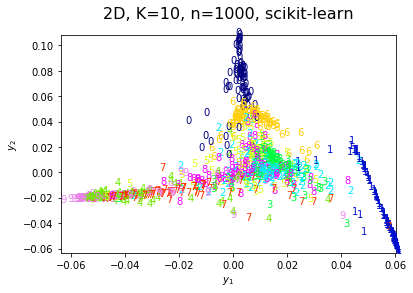

In [606]:
from sklearn import manifold
clf = manifold.LocallyLinearEmbedding(10, n_components=2, method='standard')
lle = clf.fit_transform(data_small)
plot_mnist_2D(lle, labels_small, "2D, K=10, n=1000, scikit-learn")

### scikit learn LLE 3D

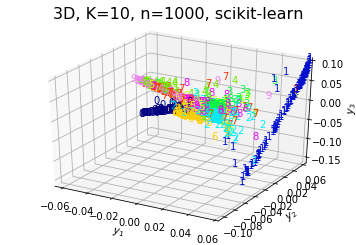

In [607]:
clf = manifold.LocallyLinearEmbedding(10, n_components=3, method='standard')
lle = clf.fit_transform(data_small)
plot_mnist_3D(lle, labels_small, "3D, K=10, n=1000, scikit-learn")

## Implement my own LLE

In [632]:
import scipy.spatial
import scipy.linalg
import time

def findNeighborhoods(data, K, n_finder, ni=None):
    N = data.shape[0]
    if n_finder=='default':
        if ni == None:
            kdt = scipy.spatial.cKDTree(data)
        else:
            kdt = ni
        _,q = kdt.query(data, K+1) #+1 because we also always get the point itself
        ni = kdt
    elif n_finder=='mi':
        if ni == None:
            MI = np.zeros( (N,N) )
            for i in range(N):
                for j in range(i):
                    m = sklearn.metrics.mutual_info_score(data[i,:], data[j, :])
                    MI[i,j] = m
                    MI[j,i] = m
                MI[i,i] = float('inf')
        else:
            MI = ni
        q = np.zeros((N,K+1))
        for i in range(N):
            m = MI[i, :]
            ids = np.argsort(-m)
            q[i,:] = ids[:K+1]
        q = q.astype(int)
        ni = MI
    return q, ni

def calculateWeights(q, data, K):
    N = data.shape[0]
    W = np.zeros( (N,N) )
    for i in xrange(N):
        neighborhood = q[i][1:]
        C = np.zeros( (K,K) )
        xi = data[i, :]
        for k in xrange(K):
            xk = data[neighborhood[k], :]
            diffk = xi - xk
            for l in xrange(k):
                xl = data[neighborhood[l], :]
                diffl = xi - xl
                C[k,l] = diffk.dot(diffl)
                C[l,k] = diffl.dot(diffk)
            C[k,k] = diffk.dot(diffk)
        C = C + (1.0/K) * np.eye(K)
        C_inv = np.linalg.inv(C)
        noms = np.sum(C_inv, axis=1) #row wise sum
        denom = np.sum(C_inv)        
        w_ij = noms/denom
        W[i, neighborhood] = w_ij
    return W
    
def lle(data, labels, K, d, n_finder='default', ni=None):
    N = data.shape[0]
    
    
    #find neighborhoods
    t0 = time.clock()
    q,ni = findNeighborhoods(data, K, n_finder, ni)
    t1 = time.clock()
        
    print "finding neighbours took", (t1-t0)

    #calculate weights
    W = calculateWeights(q, data, K)
    t2 = time.clock()
    print "calculating W took", (t2-t1)


    #find Y
    M = (np.eye(N) - W).T.dot((np.eye(N)-W))
    e, v = scipy.linalg.eigh(M, eigvals=(0, d+1))
    Y = v[:,1:(d+1)]
    t3 = time.clock()
    print "calculating Y took", (t3-t2)
    return Y,M,ni



## Plot LLE
### 2D, 1000 data points, K = 10

finding neighbours took 0.940142000003
calculating W took 0.230885999998
calculating Y took 0.297686000002


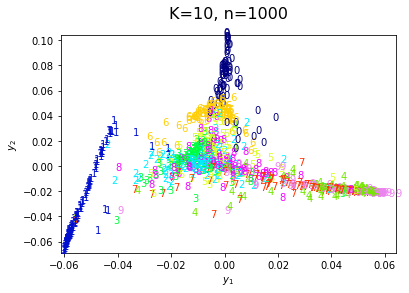

In [633]:
data = data_small
labels = labels_small
Y,M,_ = lle(data, labels, 10, 2)
plot_mnist_2D(Y, labels, "K=10, n=1000")

### 3D, 1000 data points, K = 10

finding neighbours took 0.918797
calculating W took 0.242373999999
calculating Y took 0.295829000001


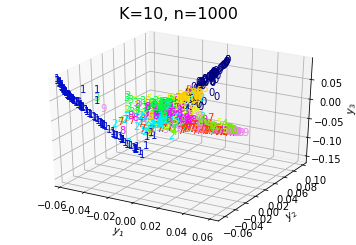

In [610]:
data = data_small
labels = labels_small
Y,M,_ = lle(data, labels, 10, 3)
plot_mnist_3D(Y, labels, "K=10, n=1000")

### 2D, 10k data points, K = 10

finding neighbours took 100.306784
calculating W took 3.379105
calculating Y took 344.092498


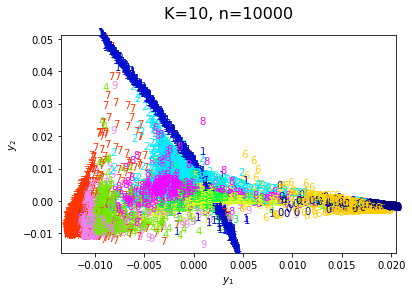

In [611]:
data = data_10k
labels = labels_10k
Y,M,_ = lle(data, labels, 10, 2)
plot_mnist_2D(Y, labels, "K=10, n=10000")

### 3D, 10k data points, K = 10

finding neighbours took 94.903158
calculating W took 2.593272
calculating Y took 366.896849


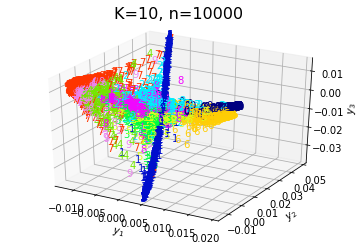

In [612]:
data = data_10k
labels = labels_10k
Y,M,_ = lle(data, labels, 10, 3)
plot_mnist_3D(Y, labels, "K=10, n=10000")

## Investigate Structure of M

In [613]:
def visualize_M(M, labels, title):
    plt.spy(M)
    plt.show()

    inds = labels.argsort()
    M_new = M[inds]
    M_new = M_new[:, inds]

    plt.spy(M_new)
    start = 0
    cmap = cm.gist_ncar
    ticks = []
    for i in range(0, 10):
        c = len(filter(lambda x: x == i, labels))
        plt.axhspan(start, start+c, facecolor=cmap(0.1*i), alpha=0.3)
        plt.axvspan(start, start+c, facecolor=str(0.1*i), alpha=0.5)
        ticks.append(start + c/2.0)
        start = start + c
    plt.xticks(ticks, range(10))
    plt.yticks(ticks, range(10))
        #     plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)
    plt.xlabel('$\mathbf{x}_j$')
    plt.gca().xaxis.set_label_position('top') 
    plt.ylabel('$\mathbf{x}_i$')
    plt.title(title, y=1.15, fontsize=16)
    plt.show()

### Investigate M for n = 1000

finding neighbours took 0.879822000001
calculating W took 0.241931999999
calculating Y took 0.288528000001


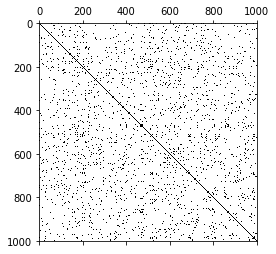

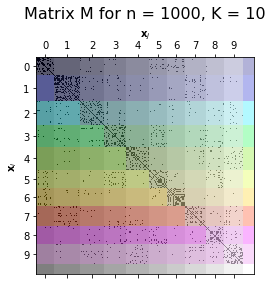

In [614]:
data = data_small
labels = labels_small
Y,M,_ = lle(data, labels, 10, 2)
visualize_M(M, labels, 'Matrix M for n = 1000, K = 10')


### Investigate M for n = 10000

finding neighbours took 97.651067
calculating W took 2.844316
calculating Y took 366.563155


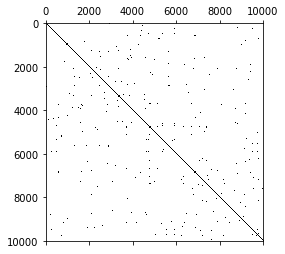

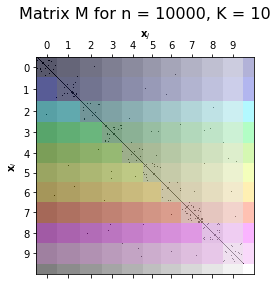

In [615]:
data = data_10k
labels = labels_10k
Y,M,_ = lle(data, labels, 10, 2)
visualize_M(M, labels, 'Matrix M for n = 10000, K = 10')

### Investigate the singular values of M

In [616]:
U, s, V = np.linalg.svd(M)
print s


[  8.75084912e+00   8.38084991e+00   7.29981024e+00 ...,   1.71943974e-05
   1.12652538e-05   3.72591749e-15]


201

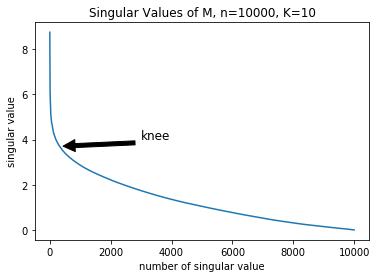

In [617]:

plt.plot(s)
plt.title("Singular Values of M, n=10000, K=10")
plt.xlabel("number of singular value")
plt.ylabel("singular value")
plt.annotate('knee',
            xy=(300, 3.7),  # theta, radius
             xytext=(3000,4),
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=12)
len(filter(lambda x: x > 4.0, s))

## Other Distance Metric: Mutual information

As we are dealing with images, the euclidian distance might not be the best. Here I try the mutual information between images as their distance.

In [620]:
data = data_small

n = data.shape[0]
MI = np.zeros( (n,n) )

for i in range(n):
    for j in range(i):
        m = sklearn.metrics.mutual_info_score(data[i,:], data[j, :])
        MI[i,j] = m
        MI[j,i] = m
    MI[i,i] = float("inf")

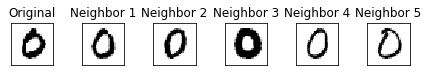

In [621]:
K = 5
i = 3
m = MI[i, :]
ids = np.argsort(-m)

plt.figure()
f, ax = plt.subplots(1,1+K)
ax[0].imshow(np.reshape(data[i,:], (28,28)), cmap='gray_r')
ax[0].set_title("Original")
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
for j in range(K):
    ax[1+j].imshow(np.reshape(data[ ids[j+1] ,:], (28,28)), cmap='gray_r')
    ax[1+j].set_title("Neighbor "+str(j+1))
    ax[1+j].get_xaxis().set_ticks([])
    ax[1+j].get_yaxis().set_ticks([])
f.tight_layout()

### Compute LLE with MI metric

finding neighbours took 1.443706
calculating W took 0.0237830000005
calculating Y took 0.000992000001133
finding neighbours took 0.00219599999764
calculating W took 0.0269880000014
calculating Y took 0.00131700000202


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


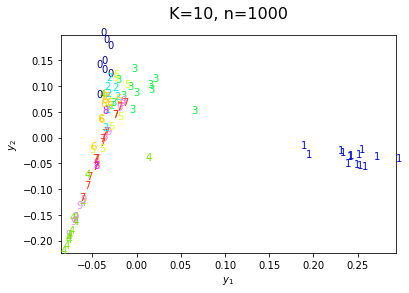

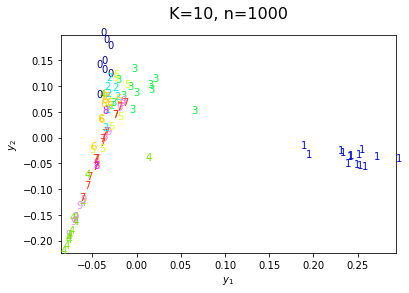

In [622]:
data = data_small[:100]
labels = labels_small[:100]
Y,M,MI = lle(data, labels, 10, 2, "mi")
plot_mnist_2D(Y, labels, "K=10, n=1000")

Y,M,MI = lle(data, labels, 10, 2, "mi", MI)
plot_mnist_2D(Y, labels, "K=10, n=1000")

# Y,M = lle(data, labels, 5, 2, "mi")
# plot_mnist_2D(Y, labels, "K=5, n=1000")

# Y,M = lle(data, labels, 20, 2, "mi")
# plot_mnist_2D(Y, labels, "K=20, n=1000")

# Y,M = lle(data, labels, 10, 3, "mi")
# plot_mnist_3D(Y, labels, "K=10, n=1000")

finding neighbours took 0.00159899999926
calculating W took 0.0131199999996
calculating Y took 0.0012560000032


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:15: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


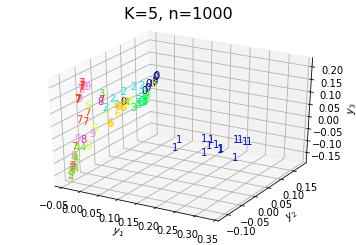

In [624]:
Y,M,_ = lle(data, labels, 5, 3, "mi", MI)
plot_mnist_3D(Y, labels, "K=5, n=1000")

## Reconstructing the original vectors

In [625]:
def reconstruct(i, data, q, W):
    neighbors = q_emb[i, 1:K+1]
    X = W[i,neighbors].dot(data[neighbors,:])
    return X

## Datapoint in embedding space

finding neighbours took 1.14015
calculating W took 0.249196000001
calculating Y took 0.336045


[]

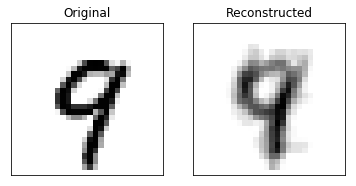

In [626]:
data = data_small
labels = labels_small
K = 9
d = 2
Y,M,_ = lle(data, labels, K, d)

q_emb,_ = findNeighborhoods(Y, K, 'default')
q_orig,_ = findNeighborhoods(data, K, 'default')
W = calculateWeights(q_emb, Y, K)
N = data.shape[0]


i = 12
X = reconstruct(i, data, q_emb, W)

plt.figure()
f, ax = plt.subplots(1,2)
ax[0].imshow(np.reshape(data[i,:], (28,28)), cmap='gray_r')
ax[1].imshow(np.reshape(X, (28,28)), cmap='gray_r')
ax[0].set_title("Original")
ax[1].set_title("Reconstructed")
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
# f.tight_layout()

## Reconstruct line in manifold

In [627]:
#zeros and sixes are conncted clusters
#i pick a random 0 and a random 6 and plot the line between them

data = data_small
labels = labels_small
K = 9
d = 2
Y,M,_ = lle(data, labels, K, d)

finding neighbours took 0.968507999998
calculating W took 0.213392000001
calculating Y took 0.292117000001


In [628]:
threes = np.where(labels == 3)
threes  = threes[0]
a = np.random.choice(threes, 1)[0]

sevens = np.where(labels == 7)
sevens  = sevens[0]
b = np.random.choice(sevens, 1)[0]

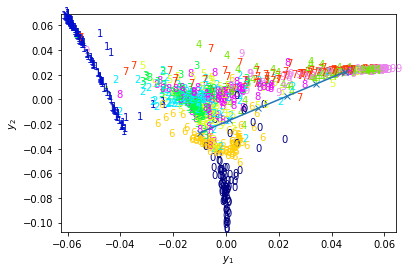

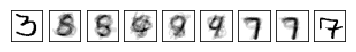

In [629]:
#interpolate in 5 steps
steps = 5
start = Y[a,:]
end = Y[b, :]
direction = end - start

# points = [start]
points = []
for i in range(1,steps+1):
    points.append(start + ((1.0*i)/(steps) ) * direction )
# points.append(end)
plot_points = np.asarray([start]+points+[end])
points = np.asarray(points)

ax = plot_mnist_2D(Y, labels, "")
ax.plot(plot_points[:,0], plot_points[:,1], 'x-', zorder=9)
plt.show()

#add new points to the dataset
Y_new = np.vstack( (Y, points) )

#reconstruct points
kdt = scipy.spatial.cKDTree(Y)
_,q_emb_1 = kdt.query(Y, K+1)
_,q_emb_2 = kdt.query(points, K)
q_emb_2 = np.hstack( (q_emb_2, np.zeros((q_emb_2.shape[0], 1)) ) )
q_emb = np.vstack((q_emb_1, q_emb_2))
q_emb = q_emb.astype(int)

W = calculateWeights(q_emb, Y_new, K)



# plt.figure()
# plt.imshow(np.reshape(X, (28,28)))
# for j in range(1,steps):
#     i = Y.shape[0] -1 + j
#     X = reconstruct(data, q_emb[i, 1:K+1], W[i])
#     plt.figure()
#     plt.imshow(np.reshape(X, (28,28)))
# X = reconstruct(data, q_emb[b, 1:K+1], W[b])
# plt.figure()
# plt.imshow(np.reshape(X, (28,28)))



plt.figure() #figsize=(20,2)
f, ax = plt.subplots(1,2+2+steps)
ax[0].imshow(np.reshape(data[a,:], (28,28)), cmap='gray_r')
ax[1].imshow(np.reshape(reconstruct(a, data, q_emb, W), (28,28)), cmap='gray_r')
ax[0].get_xaxis().set_ticks([])
ax[0].get_yaxis().set_ticks([])
ax[1].get_xaxis().set_ticks([])
ax[1].get_yaxis().set_ticks([])
for j in range(steps):
    i = 1 + 1 + j
    ax[i].imshow(np.reshape(reconstruct(data.shape[0]+j, data, q_emb, W), (28,28)), cmap='gray_r')
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
#     ax[i].set_title("Reconstructed\nInterpolation")
ax[2 + steps].imshow(np.reshape(reconstruct(b, data, q_emb, W), (28,28)), cmap='gray_r')
ax[2 + steps + 1].imshow(np.reshape(data[b,:], (28,28)), cmap='gray_r')
ax[2 + steps].get_xaxis().set_ticks([])
ax[2 + steps].get_yaxis().set_ticks([])
ax[2 + steps + 1].get_xaxis().set_ticks([])
ax[2 + steps + 1].get_yaxis().set_ticks([])
# f.tight_layout()
plt.show()

## Reconstruct line outside the manifold

finding neighbours took 0.916109000002
calculating W took 0.206104000001
calculating Y took 0.307118000001
(10, 2)
[[ 0.02       -0.1       ]
 [ 0.02444444 -0.08888889]
 [ 0.02888889 -0.07777778]
 [ 0.03333333 -0.06666667]
 [ 0.03777778 -0.05555556]
 [ 0.04222222 -0.04444444]
 [ 0.04666667 -0.03333333]
 [ 0.05111111 -0.02222222]
 [ 0.05555556 -0.01111111]
 [ 0.06        0.        ]]


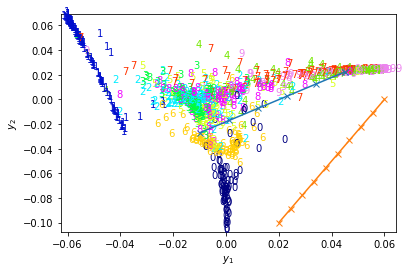

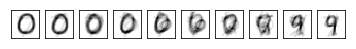

In [630]:
#zeros and sixes are conncted clusters
#i pick a random 0 and a random 6 and plot the line between them

data = data_small
labels = labels_small
K = 9
d = 2
Y,M,_ = lle(data, labels, K, d)
ax = plot_mnist_2D(Y, labels, "")

#(0.02, 0.10) -> (0.06, 0.04) is a line clearly not in the plot
#interpolate in 5 steps
steps = 10
start = np.array([0.02, -0.10])
end = np.array([0.06, 0])

direction = end - start
points = []
for i in range(steps):
    points.append(start + ((1.0*i)/(steps-1)) *direction )
points = np.asarray(points)
print points.shape
print points
ax.plot(plot_points[:,0], plot_points[:,1], 'x-', zorder=9)
ax.plot(points[:,0], points[:,1], 'x-')
plt.show()


#add new points to the dataset
Y_new = np.vstack( (Y, points) )

#reconstruct points
kdt = scipy.spatial.cKDTree(Y)
_,q_emb_1 = kdt.query(Y, K+1)
_,q_emb_2 = kdt.query(points, K)
q_emb_2 = np.hstack( (q_emb_2, np.zeros((q_emb_2.shape[0], 1)) ) )
q_emb = np.vstack((q_emb_1, q_emb_2))
q_emb = q_emb.astype(int)

W = calculateWeights(q_emb, Y_new, K)


plt.figure() #figsize=(20,2)
f, ax = plt.subplots(1,steps)
for i in range(steps):
    ax[i].imshow(np.reshape(reconstruct(data.shape[0]+i, data, q_emb, W), (28,28)), cmap='gray_r')
    ax[i].get_xaxis().set_ticks([])
    ax[i].get_yaxis().set_ticks([])
#     ax[i].set_title("Reconstructed\nInterpolation")
plt.show()




## t-SNE, PCA

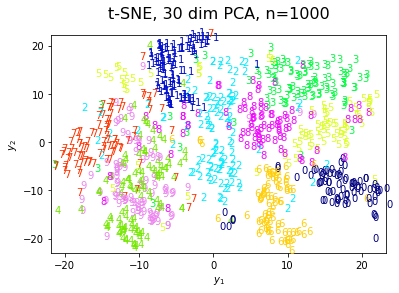

In [653]:
data = data_small
labels = labels_small
Y = sklearn.manifold.TSNE().fit_transform(data)
ax = plot_mnist_2D(Y, labels, "t-SNE, 30 dim PCA, n=1000")

finding neighbours took 0.0762560000003
calculating W took 0.158836999999
calculating Y took 0.363787999999


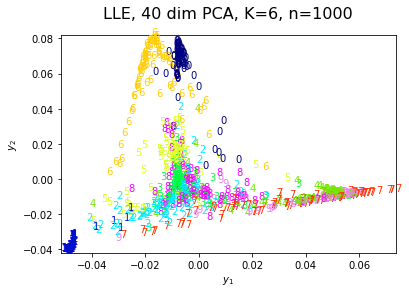

In [652]:
data = sklearn.decomposition.PCA(n_components=40).fit_transform(data)
Y,M,_ = lle(data, labels, 6, d)
ax = plot_mnist_2D(Y, labels, "LLE, 40 dim PCA, K=6, n=1000")